In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import mpl
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
color = sns.color_palette()
# sns.set_style('darkgrid')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
train_df = pd.read_csv('../data/train.csv', encoding='gbk')
test_df = pd.read_csv('../data/test.csv', encoding='gbk')
train_df.shape

(5642, 42)

In [3]:
# 空值填充分两种，一种是空置太多的直接删除特征，一种是用均值或中值填充
def checknan(df):
    colnan = df.count() / df.shape[0]
    colnan = colnan[colnan < 0.5]
    return list(colnan.index)
def drop_fill(df):
    delcols = checknan(df)
    df.drop(delcols, 1, inplace=True) #删除缺失值多于一半的特征
    df.drop(['体检日期'], 1 ,inplace=True)
    df.fillna(-999, inplace=True)
    return df
def encode_cols(df):
    if isinstance(df['性别'][1],int):
        return 
    else:
        df['性别'] = df['性别'].map({'男': 0, '女': 1, '??': 3})
        return df
    
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
train_df = drop_fill(train_df)
encode_cols(train_df)

#新建特征
train_df['高低胆固醇比例'] = train_df['低密度脂蛋白胆固醇'] / train_df['高密度脂蛋白胆固醇']
train_df['红白细胞比例'] = train_df['白细胞计数'] / train_df['红细胞计数']
train_df.drop(['id'], 1 ,inplace=True)

x = np.array(train_df.drop([ '血糖'], axis=1))
y = np.array(train_df['血糖'])

In [4]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [5]:
def show_scatter(y, y_pred, legend0, legend1, showlenth=10):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(range(showlenth),y[:showlenth], label=legend0)
    ax.scatter(range(showlenth),y_pred[:showlenth],label =legend1)
    plt.legend()
    plt.show()

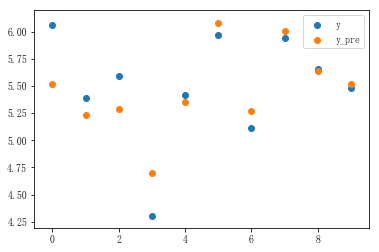

original train score: 0.860086410545


In [9]:
# Randomforest 默认参数
model_rf = CatBoostRegressor(random_seed=100)
model_rf.fit(x, y,verbose=False,logging_level='Silent')
y_pred = model_rf.predict(x)
show_scatter(y, y_pred, 'y', 'y_pre')
print('original train score:',metrics.mean_squared_error(y, y_pred))

In [ ]:
param_test1 = {'n_estimators':range(10,101,10)}
grid_cv = GridSearchCV(estimator=model_rf, param_grid= param_test1, scoring='neg_mean_squared_error', cv=5)
grid_cv.fit(x, y)